The goal of the analysis in this notebook is to determine what users at Relax inc are adopted users (Defining an "adopted user" as a user who has logged into the product on 3 separate days in at least one 7-­day period) and identifying which factors predict future user adoption.

First import pacakgages.

In [54]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Import chardet and codecs
import chardet

# Import datetime
from datetime import datetime

# Import vizualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Import modeling tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

Read in the csv files with the data.

In [2]:
# Import dataframes with user information and user engagement
with open('takehome_users.csv', 'rb') as f:
    result = chardet.detect(f.read())

users = pd.read_csv('takehome_users.csv', encoding=result['encoding'])
engagement = pd.read_csv('takehome_user_engagement.csv')

Inspect the dataframes and figure out their information (data types, size, etc.).

In [3]:
# Look at the first few rows of users
users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [4]:
# Look at the first few rows of engagement
engagement.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [5]:
# Check out information about the dataframe
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
# Check out information about the dataframe
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Modify the engagement dataframe to determine which users are adopted users. First create new columns which capture the year and calendar week of each user's sign in.  Group the dataframe by user, year and week in that order. Then count how many times a user signs in in these groupings. If more than 3 times then the user is an adopted user.

In [7]:
# Convert 'time_stamp' column in engagement to datetime format
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [8]:
# Create new year and week of the calendar year columns in engagement
engagement['year'] = engagement['time_stamp'].dt.year
engagement['week'] = engagement['time_stamp'].dt.isocalendar().week

In [9]:
# Create new dataframe weekly activity, grouping engagement by user_id, then year
# then week. Find the size (number of rows in each group) and reset that as
#active days
weekly_activity = engagement.\
groupby(['user_id', 'year', 'week']).\
size().reset_index(name='active_days')

# Order weekly activity in descending numbers
weekly_activity= weekly_activity.\
sort_values(by=['active_days'], ascending = False)
weekly_activity.head(3)

,user_id,year,week,active_days
37212,6282,2013,1,8
19020,3269,2013,1,8
23261,4022,2013,1,8


In [10]:
# Filter on active days which are greater or equal to 3
active_weeks = weekly_activity[weekly_activity['active_days'] >= 3]
active_weeks.head(3)

,user_id,year,week,active_days
37212,6282,2013,1,8
19020,3269,2013,1,8
23261,4022,2013,1,8


In [11]:
# Create a column called 'adopted_user' and set = 1
active_weeks.loc[:, 'adopted_user'] = 1

<ipython-input-11-2ec323aca4b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_weeks.loc[:, 'adopted_user'] = 1


In [12]:
# Create an array of the user ids of adopted users
adopted_user_id = active_weeks['user_id'].unique()

# Create new column 'adopted_user' and set to 1 if user id is in adopted_user_id
# else set to 0.
engagement['adopted_user'] = np.where(engagement['user_id']\
                                      .isin(adopted_user_id), 1, 0)

In [53]:
# Count number of adopted and non-adopted users
engagement['adopted_user'].value_counts()

,count
adopted_user,
1,196401
0,11516


There are 17 times more adopted than non-adopted users which creates a class imbalance in the target variable. This should be accounted for while modelling.

Next, join the engagement data frame with the uders dataframe on user_id. Create numerical features to understand what factors predict future user adoption.

First, one-hot encode creation_source variables. The convert the True and False entries for the dummy variables to 1 and 0, respectively.

Next use user emails as another variable by extracting the most common domains and encoding them as integers.


Next create numerical features related to the year and month, and day when a user's account was created. Finally create another feature that calculates how long a user has been a user (user tenure) based on when the account was created and their last log in.

In [13]:
# Rename user object_id as user_id
users.rename(columns = {'object_id':'user_id'}, inplace = True)

# Join the two dataframes using a left outer join to keep all user information
df_merge = pd.merge(users, engagement, on='user_id', how='left')
df_merge.head(3)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,year,week,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1.0,2014.0,17,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1.0,2013.0,46,1.0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1.0,2013.0,48,1.0


In [14]:
# Create dummy variables for creation sources
df_draft= pd.get_dummies(df_merge, columns = ['creation_source'])
df_draft.head(2)

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,year,week,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1.0,2014.0,17,0.0,True,False,False,False,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1.0,2013.0,46,1.0,False,True,False,False,False


In [15]:
# Set dummy variables as 0 for False and 1 for True
df_draft[['creation_source_GUEST_INVITE','creation_source_SIGNUP',\
        'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',\
        'creation_source_SIGNUP_GOOGLE_AUTH']]=\
        np.where(df_draft.loc[:, ['creation_source_GUEST_INVITE',\
        'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',\
        'creation_source_SIGNUP',\
                                 'creation_source_SIGNUP_GOOGLE_AUTH']]\
                  == False, 0, 1)

In [16]:
# Check if one head encoded columns are filled with 0 and 1
#  instead of True and False.
df_draft.head(3)

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,year,week,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1.0,2014.0,17,0.0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1.0,2013.0,46,1.0,0,0,0,1,0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1.0,2013.0,48,1.0,0,0,0,1,0


In [17]:
#Create a column for domain
df_draft['email_domain'] = df_draft['email'].str.split('@').str[1]
domains = df_draft['email_domain'].value_counts()

# Calculate % count of each domain name
(domains/(domains.sum())*100).head(10)

,count
email_domain,
gmail.com,34.080552
yahoo.com,15.221655
hotmail.com,12.220148
jourrapide.com,11.203540
gustr.com,9.401499
cuvox.de,7.995016
qqgix.com,0.279496
nrwjd.com,0.246809
fkhiq.com,0.222650


The first 6 domains account for ~90% of the entries. Only use the first 6 domains as individual domains and assign other domains to a group called 'Others'.

In [18]:
# Create an array of domain indices
domain_indices = domains.index

# Use apply to assign email domains to 'Other' if not one of the first
# 6 domains.
df_draft.loc[:,'email_domain'] =\
 df_draft.apply(lambda row: row['email_domain']\
          if row['email_domain'] in domain_indices[:6]\
          else 'Other', axis = 1 )

In [19]:
# Create new column domain_num which maps domain to numerical value
df_draft.loc[df_draft['email_domain'] == 'gmail.com', 'domain_num'] = 1
df_draft.loc[df_draft['email_domain'] == 'yahoo.com', 'domain_num'] = 2
df_draft.loc[df_draft['email_domain'] == 'hotmail.com', 'domain_num'] = 3
df_draft.loc[df_draft['email_domain'] == 'jourrapide.com', 'domain_num'] = 4
df_draft.loc[df_draft['email_domain'] == 'gustr.com', 'domain_num'] = 5
df_draft.loc[df_draft['email_domain'] == 'gustr.com', 'domain_num'] = 6
df_draft.loc[df_draft['email_domain'] == 'Other', 'domain_num'] = 7

Fill columns with null values greater than 5%. All other columns with null values less than 5% will be dropped. Drop non numerical features or features which have had new features calculated from them.

In [20]:
# Find # null values in each column
round(df_draft.isnull().sum()/df_draft.shape[0]*100,1)

,0
user_id,0.0
creation_time,0.0
name,0.0
email,0.0
last_session_creation_time,1.5
opted_in_to_mailing_list,0.0
enabled_for_marketing_drip,0.0
org_id,0.0
invited_by_user_id,43.9
time_stamp,1.5


In [21]:
# Check if there are any invited_by_user values set as 0
df_draft[df_draft['invited_by_user_id'] == 0.]

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,...,year,week,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_domain,domain_num


In [22]:
# Fill invited_by_user entries where user has not been invited by anyone with 0
df_draft['invited_by_user_id'].fillna(0, inplace=True)

In [23]:
# Drop the remaining NaN values from the dataframe because these are less than
# 5% of the entries
df_draft = df_draft.dropna()

# Check if the dataframe has empty values
round(df_draft.isnull().sum()/df_draft.shape[0]*100,5)

,0
user_id,0.0
creation_time,0.0
name,0.0
email,0.0
last_session_creation_time,0.0
opted_in_to_mailing_list,0.0
enabled_for_marketing_drip,0.0
org_id,0.0
invited_by_user_id,0.0
time_stamp,0.0


In [24]:
# Convert account creation time to datetime
df_draft['creation_time'] = pd.to_datetime(df_draft['creation_time'])

# Create new columns labelled month and year account created
df_draft.loc[:, 'year_created'] = df_draft['creation_time'].dt.year
df_draft.loc[:, 'monthcreated'] = df_draft['creation_time'].dt.month
df_draft.loc[:, 'day_created'] = df_draft['creation_time'].dt.day

# Convert 'last_session_creation_time'to datetime
df_draft.loc[:, 'last_session_creation_time'] =\
 df_draft.apply(lambda row:\
          datetime.fromtimestamp(row['last_session_creation_time']), axis = 1)

In [25]:
# Calculate tenure of each user
df_draft['user_tenure'] = (df_draft['last_session_creation_time'] - df_draft['creation_time']).dt.days

In [37]:
# Check features
df_draft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191414 entries, 0 to 211093
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   user_id                             191414 non-null  int64         
 1   creation_time                       191414 non-null  datetime64[ns]
 2   name                                191414 non-null  object        
 3   email                               191414 non-null  object        
 4   last_session_creation_time          191414 non-null  datetime64[ns]
 5   opted_in_to_mailing_list            191414 non-null  int64         
 6   enabled_for_marketing_drip          191414 non-null  int64         
 7   org_id                              191414 non-null  int64         
 8   invited_by_user_id                  191414 non-null  float64       
 9   time_stamp                          191414 non-null  datetime64[ns]
 10  visited      

In [41]:
df = df_draft.drop(\
 ['name', 'email', 'creation_time',
  'last_session_creation_time', 'time_stamp', 'visited',\
  'email_domain', 'user_id'], axis = 1)
df.head(3)

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,year,week,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,domain_num,year_created,monthcreated,day_created,user_tenure
0,1,0,11,10803.0,2014.0,17,0.0,1,0,0,0,0,2.0,2014,4,22,0
1,0,0,1,316.0,2013.0,46,1.0,0,0,0,1,0,6.0,2013,11,15,136
2,0,0,1,316.0,2013.0,48,1.0,0,0,0,1,0,6.0,2013,11,15,136


Check the heat map to see what features have a largely positive or negative correlation with the adopted_user variable.

<Axes: >

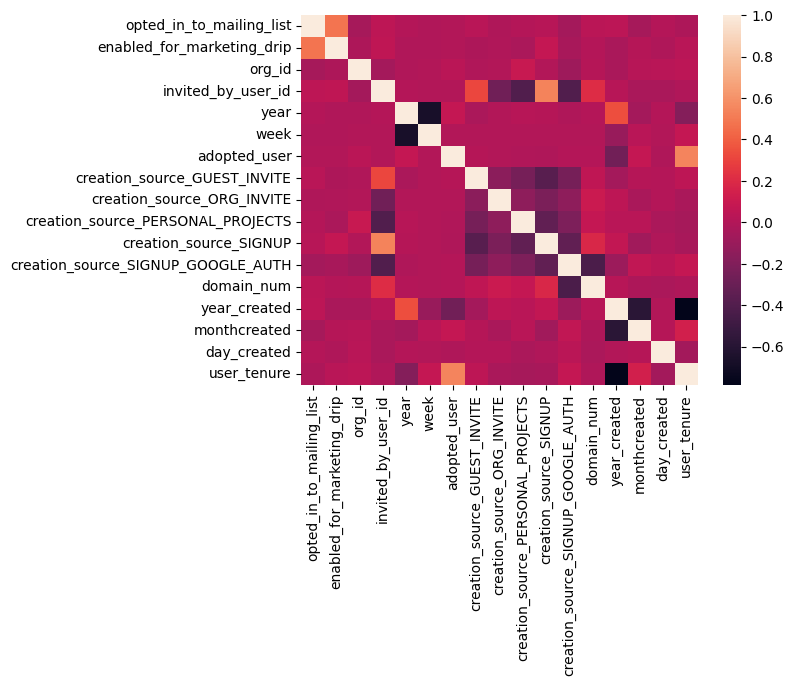

In [42]:
# Create a heat map of correlations
sns.heatmap(df.corr())

The user_tenure has the highest positive correlation with the adopted user variable. The year and month created as well as organization id also have some correlation.

Next we will perform a random forest classification to understand which variable contribute to the correlation.

In [44]:
# Set adopted user as target variable
y = df['adopted_user']

#Set the rest of the features from df as explanatory variables
X = df.drop('adopted_user', axis = 1)

# Split data into test and training set for predicting inspection scores
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [45]:
# Scale the numerical features of the dataframe using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
# Intialize the random forest classifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1, class_weight='balanced_subsample')
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=1.000
Random Forest: f1-score=1.000


Plot the feature importances for the model. Code taken from the RandomForest Covid case study.

16


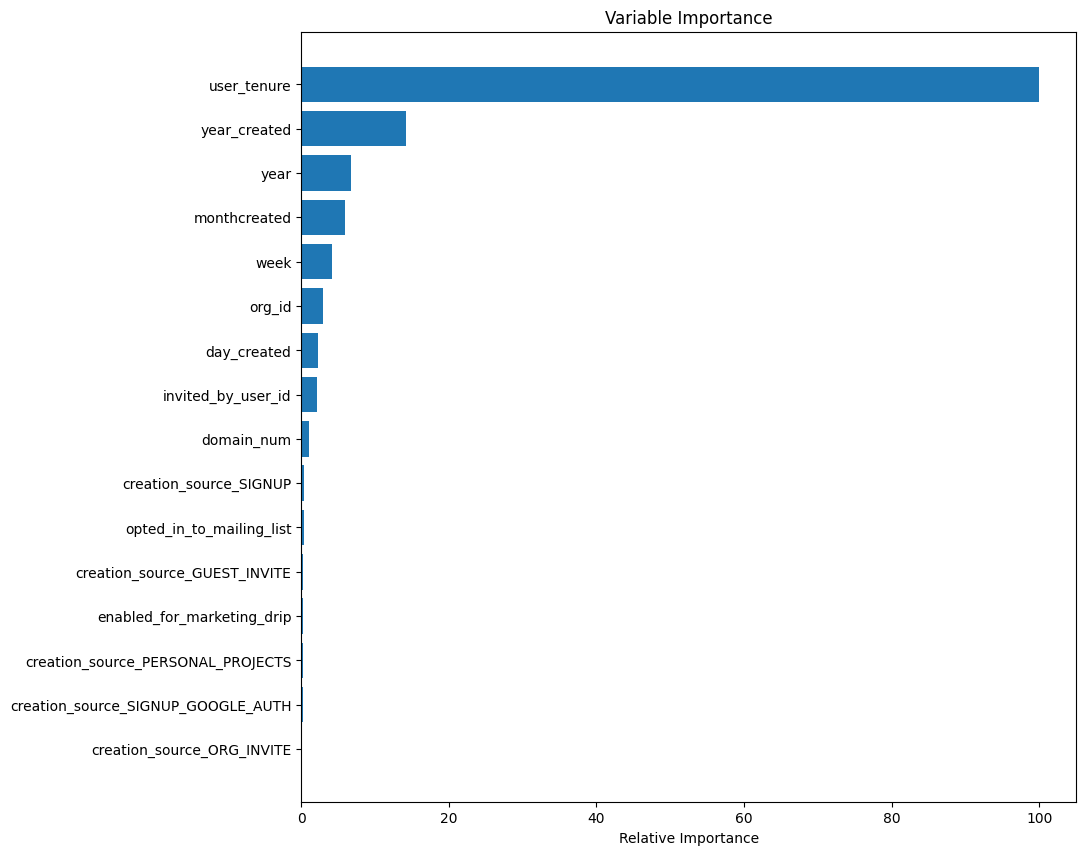

In [58]:
# Extract feature importance
feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

As shown in the heatmap, the user_tenure has the highest feature importance followed by the year the account was created, the year of the last log in, the month created and the week of the last log in. These years or weeks of logins could be related to certain events or marketing drives Relax Inc. has set up. Furthermore, it is interesting to see that certain users who invite users to Relax Inc's platforms also impact the ability to predict adopted users. Inviting users who impact adoption should be explored and why they have more impact over others.